In [1]:
import torch
import torch.nn.functional as F
from torch import Tensor
from torch import nn
from torch.nn import Parameter
from torchvision import transforms
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from torch.optim.optimizer import Optimizer, required

import os
import sys
import time
import gdown
import zipfile38 as zipfile
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from natsort import natsorted
from tqdm import tqdm
from PIL import Image

In [2]:
%matplotlib inline 
plt.style.use("ggplot")
# show image sample with matplotlib
def plot_torch_image(img, **kwargs):
    '''
    Input image is a torch tensor with the following dims (C,H,W)
    To plot it with matplotlib, we need to change it to (H,W,C) 
    kwargs varaible is used to pass other parameters to 'imshow' function.
    '''
    plt.imshow(img.permute(1, 2, 0) , **kwargs)

# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    batch_size_ = x.size(0)
    for img_idx in range(batch_size_):
        for ch_idx in range(config.image_C): #Normalize each channel independently
            ch_data = x[img_idx][ch_idx].view(1, -1)
            ch_data -= ch_data.min(1, keepdim=True)[0]
            ch_data /= ch_data.max(1, keepdim=True)[0]
            ch_data = ch_data.view(1, 1, config.image_H, config.image_W)
            x[img_idx][ch_idx] = ch_data
    return x

def ts_print(msg):
    print(f'[{datetime.now()}] -- {msg}')

### Configuration

In [3]:
class CFG:
    def __init__(self):    
        # URLS and paths
        # URL for the CelebA dataset
        self.url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
        # Path to download the dataset to
        self.data_root = './data/celeba'
        self.download_path = f'{self.data_root}/img_align_celeba.zip'
        self.dataset_folder = f'{self.data_root}/img_align_celeba'
        self.img_folder = f'{self.dataset_folder}/img_align_celeba'
        # Output path
        self.sample_dir = "06.06_DcGAN_celebA_metrics_TTUR_Noise_label_smoothing_SN_Teacher-Baseline(x4-features)_wider-latent"
        
        # dataset config
        self.image_dim = 64
        self.image_W = self.image_dim
        self.image_H = self.image_dim
        self.image_C = 3
        self.image_size = self.image_W * self.image_H * self.image_C # 28*28 flatten       
        self.ds_virtual_size = 640
        self.use_virtual_ds_size = False
        
        # Model config
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.batch_size = 128
        self.num_epochs = 20
        self.latent_size = 128 # input random input vector latent
        self.ngf = 128 #Size of feature maps in generator
        self.ndf = 128 #Size of feature maps in discriminator
        self.dlr = 0.0001
        self.glr = 0.0002
        self.lrelu_slope = 0.2
        self.label_smooth = 0.9 # No smoothing
        self.noise_coef = 0.005 # No noise
        self.pre_load=False
        self.dropout_rate_g = 0.0
        self.dropout_rate_d = 0.0

        # Create required directories, install dataset and extract it (~1.6GB)
        if not os.path.exists(self.data_root):
            os.makedirs(self.data_root)
            os.makedirs(self.dataset_folder)
            # Download the dataset from google drive
            gdown.download(self.url, self.download_path, quiet=False)

            # Unzip the downloaded file 
            with zipfile.ZipFile(self.download_path, 'r') as ziphandler:
                ziphandler.extractall(self.dataset_folder)  
                
        if not os.path.exists(self.sample_dir):
            os.makedirs(self.sample_dir)


config = CFG()
if torch.cuda.is_available():
    x = !nvidia-smi
    for line in range(1, 12):
        print(x[line])
        

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.92       Driver Version: 461.92       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8    11W /  N/A |    544MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+


In [4]:
torch.cuda.is_available()

True

### Creating CelebA Dataset

In [5]:
## Create a custom Dataset class
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None, pre_load = True, use_virtual_ds_size = True):
        """
        Args:
          root_dir (string): Directory with all the images
          transform (callable, optional): transform to be applied to each image sample
        """
        # Read names of images in the root directory
        image_names = os.listdir(root_dir)

        self.root_dir = root_dir
        self.transform = transform 
        self.image_names = natsorted(image_names)
        self.pre_load = pre_load
        self.use_virtual_ds_size = use_virtual_ds_size
        
        if self.pre_load is True:
            ts_print("Loading DS to memory")
            time.sleep(1.0)
            self.images = []
            for idx in tqdm(range(self.__len__())):
                # Get the path to the image                          
                self.images.append(self.__load_image__(idx))
            time.sleep(1.0)
            ts_print("Loading DS to memory done!")

    def __len__(self): 
        if self.use_virtual_ds_size is True:
            return min(config.ds_virtual_size, len(self.image_names))
        else:
            return len(self.image_names)
    
    def __load_image__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_names[idx])       
        # Load image and convert it to RGB
        img = Image.open(img_path).convert('RGB')
        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)
        return img
        

    def __getitem__(self, idx):
        if self.pre_load is True:
            return self.images[idx]
        else:
            return self.__load_image__(idx)
        


transform=transforms.Compose([
    transforms.Resize(config.image_dim),
    transforms.CenterCrop(config.image_dim),
    transforms.ToTensor()   
])



In [6]:
dataset = CelebADataset(root_dir=config.img_folder, transform=transform, pre_load=config.pre_load, use_virtual_ds_size=config.use_virtual_ds_size)
data_loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)

In [7]:
img = dataset[0]
print("Dataset size: ", len(dataset))
print("Image dims: ", img.size())  
# plot_torch_image(img)

Dataset size:  202599
Image dims:  torch.Size([3, 64, 64])


### Spectral Normaliztion

In [8]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

### Generator and Discriminator models

In [9]:
class Generator(nn.Module):
    def __init__(self, nc, h, w, latent_size, ngf):
        super(Generator, self).__init__()
        self.all_layers = nn.Sequential(
            nn.ConvTranspose2d(latent_size, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(),
            # nn.Dropout(config.dropout_rate_g),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(),
            # nn.Dropout(config.dropout_rate_g),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(),
            # nn.Dropout(config.dropout_rate_g),
            
            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),
            # nn.Dropout(config.dropout_rate_g),
            
            nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.all_layers(input)


class Discriminator(nn.Module):
    def __init__(self, nc, h, w, ndf):        
        super(Discriminator, self).__init__()
        self.features = nn.Sequential(
            SpectralNorm(nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(config.lrelu_slope, inplace=True),
            # nn.Dropout(config.dropout_rate_d),
            
            SpectralNorm(nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(config.lrelu_slope, inplace=True),
            # nn.Dropout(config.dropout_rate_d),
            
            SpectralNorm(nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(config.lrelu_slope, inplace=True),
            
            SpectralNorm(nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(config.lrelu_slope, inplace=True),   
        )
        self.output = nn.Sequential(
            SpectralNorm(nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False)),
            nn.Sigmoid(),
        )
    def forward(self, input):
        features = self.features(input)
        output = self.output(features)
        return output, features
    

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
# create new Generator model
G = Generator(config.image_C, config.image_H, config.image_W, config.latent_size, config.ngf)
G.apply(init_weights)
# create new Discriminator model
D = Discriminator(config.image_C, config.image_H, config.image_W, config.ndf)

G = G.to(config.device)
D = D.to(config.device)
print("models created")

models created


In [11]:
def get_latent_vector(batch_size):
    return torch.Tensor(np.random.normal(0, 1, (batch_size, config.latent_size, 1, 1)))


Min:  0.0
Max:  1.0


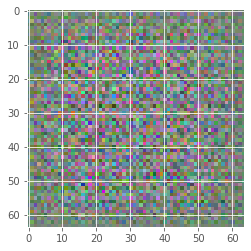

In [12]:
# show the output of model 
y = G(get_latent_vector(batch_size=1).to(config.device))
with torch.no_grad():
    for img in y:
        img = denorm(img.unsqueeze(0)).squeeze(0)
        print("Min: ", img.min().item())
        print("Max: ", img.max().item())
        plt.figure()
        plot_torch_image(img.detach().cpu())
        

### Loss functions and optimizers

In [13]:
bce_loss = nn.BCELoss() # binary cross-entropy
mse_loss = nn.MSELoss() # MSE loss
## Define the optimizer for generator and discrimator
G_optim = torch.optim.Adam(G.parameters(),betas=(0.5, 0.999),  lr=config.glr, weight_decay=1e-4, amsgrad=True)
D_optim = torch.optim.Adam(D.parameters(),betas=(0.5, 0.999),  lr=config.dlr, weight_decay=1e-4, amsgrad=True)

### Trainer function

In [14]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    G_optim.zero_grad()
    D_optim.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = (torch.ones(config.batch_size, 1) * config.label_smooth).to(config.device)
    fake_labels = (torch.ones(config.batch_size, 1) * (1 - config.label_smooth)).to(config.device)
    
    # Add noise to discriminator inputs (both the real and synthetic data) to discourage it from being overconfident 
    # about its classification, or relying on a limited set of features to distinguish between training data and 
    # generator’s output
    noise = config.noise_coef * np.random.uniform() * torch.amax(images)    
    images = images + (noise.to(config.device) * torch.randn(size=images.shape).to(config.device))
    
    
    outputs, _ = D(images)
    # Loss for real images
    loss_r = bce_loss(outputs.view(config.batch_size ,-1), real_labels)
    real_score = outputs

    # Loss for fake images
    z = get_latent_vector(batch_size = config.batch_size).to(config.device)
    noise = config.noise_coef * np.random.uniform() * torch.amax(z)    
    z = z + (noise.to(config.device) * torch.randn(size=z.shape).to(config.device))
        
    fake_images = G(z)
    
    noise = config.noise_coef * np.random.uniform() * torch.amax(fake_images)    
    fake_images = fake_images + (noise.to(config.device) * torch.randn(size=fake_images.shape).to(config.device))
    
       
    outputs, _ = D(fake_images)
    loss_f = bce_loss(outputs.view(config.batch_size ,-1), fake_labels)
    fake_score = outputs
    # Sum losses
    d_loss = loss_r + loss_f
    # Adjust the parameters using backprop
    d_loss.backward()
    # Compute gradients
    D_optim.step()
    # Reset gradients
    reset_grad()

    return d_loss, real_score, fake_score

In [15]:
def train_generator(images, use_feature_matching = True):
    # Generate fake images and calculate loss
    # z = torch.Tensor(np.random.normal(0, 1, (config.batch_size, config.latent_size))).to(config.device)
    z = get_latent_vector(batch_size = config.batch_size).to(config.device)
    # Add noise to the noisy input.
    # This helps our model better cover the input space and generate more diverse samples
    noise = config.noise_coef * np.random.uniform() * torch.amax(z)    
    z = z + (noise.to(config.device) * torch.randn(size=z.shape).to(config.device))
    
    fake_images = G(z)
    # calculate the generator loss
    if use_feature_matching is True:
        _ , feature_real = D(images)
        _, feature_fake = D(fake_images)
        feature_real = torch.mean(feature_real,0)
        feature_fake = torch.mean(feature_fake,0)
        g_loss = mse_loss(feature_fake, feature_real)
    
    else:
        labels = (torch.ones(config.batch_size, 1) * config.label_smooth).to(config.device)
        outputs, _ = D(fake_images)
        g_loss = bce_loss(outputs.view(config.batch_size,-1), labels)
        
    # Backprop and optimize
    g_loss.backward()
    G_optim.step()
    # Reset gradients
    reset_grad()
    return g_loss, fake_images

In [16]:
def save_fake_images(index):
    sample_vectors = get_latent_vector(batch_size = 10).to(config.device).to(config.device)
    
    noise =  config.noise_coef * np.random.uniform() * torch.amax(sample_vectors)    
    sample_vectors = sample_vectors + (noise.to(config.device) * torch.randn(size=sample_vectors.shape).to(config.device))
    
    fake_images = G(sample_vectors)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(config.sample_dir, fake_fname), nrow= 10)

In [17]:
%%time
print(f"[{datetime.now()}] -- Training started")
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
for epoch in range(config.num_epochs):
    for item in tqdm(enumerate(data_loader), file=sys.stdout):
        i, images = item
        # Load a batch & transform to vectors
        images = images.to(config.device)
        # Train the generator n times
        n = 2
        for _ in range(n):
            g_loss, fake_images = train_generator(images, False)
        # Train the discriminator  once
        d_loss, real_score, fake_score = train_discriminator(images)
        # Inspect the losses
        if (i+1) % 100 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            tqdm.write('[{}] -- Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(datetime.now(), epoch+1, config.num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)

[2021-12-09 19:50:37.921275] -- Training started
[2021-12-09 19:51:26.779916] -- Epoch [1/20], Step [100/1582], d_loss: 1.6423, g_loss: 0.8681, D(x): 0.47, D(G(z)): 0.54
[2021-12-09 19:52:14.177064] -- Epoch [1/20], Step [200/1582], d_loss: 1.5246, g_loss: 0.9379, D(x): 0.54, D(G(z)): 0.53
[2021-12-09 19:53:01.732184] -- Epoch [1/20], Step [300/1582], d_loss: 1.5372, g_loss: 0.8394, D(x): 0.43, D(G(z)): 0.47
[2021-12-09 19:53:49.469961] -- Epoch [1/20], Step [400/1582], d_loss: 1.4099, g_loss: 0.7082, D(x): 0.57, D(G(z)): 0.55
[2021-12-09 19:54:37.346369] -- Epoch [1/20], Step [500/1582], d_loss: 1.3712, g_loss: 0.7226, D(x): 0.57, D(G(z)): 0.53
[2021-12-09 19:55:36.073692] -- Epoch [1/20], Step [600/1582], d_loss: 1.3928, g_loss: 0.7224, D(x): 0.59, D(G(z)): 0.55
[2021-12-09 19:56:39.968447] -- Epoch [1/20], Step [700/1582], d_loss: 1.3138, g_loss: 1.0009, D(x): 0.50, D(G(z)): 0.41
[2021-12-09 19:57:44.894469] -- Epoch [1/20], Step [800/1582], d_loss: 1.4129, g_loss: 0.9151, D(x): 0.4

[2021-12-09 20:53:25.716513] -- Epoch [5/20], Step [700/1582], d_loss: 1.3331, g_loss: 0.6603, D(x): 0.57, D(G(z)): 0.52
[2021-12-09 20:54:13.670563] -- Epoch [5/20], Step [800/1582], d_loss: 1.3518, g_loss: 0.7160, D(x): 0.53, D(G(z)): 0.49
[2021-12-09 20:55:02.424956] -- Epoch [5/20], Step [900/1582], d_loss: 1.3732, g_loss: 0.8454, D(x): 0.49, D(G(z)): 0.47
[2021-12-09 20:55:51.695770] -- Epoch [5/20], Step [1000/1582], d_loss: 1.3350, g_loss: 0.6538, D(x): 0.59, D(G(z)): 0.54
[2021-12-09 20:56:39.958516] -- Epoch [5/20], Step [1100/1582], d_loss: 1.3648, g_loss: 0.8798, D(x): 0.46, D(G(z)): 0.43
[2021-12-09 20:57:28.278324] -- Epoch [5/20], Step [1200/1582], d_loss: 1.3360, g_loss: 0.7760, D(x): 0.51, D(G(z)): 0.47
[2021-12-09 20:58:17.880490] -- Epoch [5/20], Step [1300/1582], d_loss: 1.3508, g_loss: 0.7744, D(x): 0.48, D(G(z)): 0.44
[2021-12-09 20:59:06.838577] -- Epoch [5/20], Step [1400/1582], d_loss: 1.3575, g_loss: 0.7829, D(x): 0.48, D(G(z)): 0.46
[2021-12-09 20:59:55.482586

[2021-12-09 21:49:29.350664] -- Epoch [9/20], Step [1300/1582], d_loss: 1.3443, g_loss: 0.7372, D(x): 0.54, D(G(z)): 0.50
[2021-12-09 21:50:17.690032] -- Epoch [9/20], Step [1400/1582], d_loss: 1.3589, g_loss: 1.0393, D(x): 0.42, D(G(z)): 0.36
[2021-12-09 21:51:06.595106] -- Epoch [9/20], Step [1500/1582], d_loss: 1.3259, g_loss: 0.9685, D(x): 0.46, D(G(z)): 0.39
1582it [12:47,  2.06it/s]
Saving fake_images-0009.png
[2021-12-09 21:52:36.550818] -- Epoch [10/20], Step [100/1582], d_loss: 1.2389, g_loss: 0.8104, D(x): 0.52, D(G(z)): 0.42
[2021-12-09 21:53:24.765542] -- Epoch [10/20], Step [200/1582], d_loss: 1.2781, g_loss: 0.6800, D(x): 0.60, D(G(z)): 0.51
[2021-12-09 21:54:12.521632] -- Epoch [10/20], Step [300/1582], d_loss: 1.2961, g_loss: 0.8439, D(x): 0.52, D(G(z)): 0.45
[2021-12-09 21:55:01.223869] -- Epoch [10/20], Step [400/1582], d_loss: 1.3598, g_loss: 0.8052, D(x): 0.48, D(G(z)): 0.45
[2021-12-09 21:55:49.803119] -- Epoch [10/20], Step [500/1582], d_loss: 1.3074, g_loss: 1.07

[2021-12-09 22:45:08.577652] -- Epoch [14/20], Step [300/1582], d_loss: 1.2981, g_loss: 0.7737, D(x): 0.54, D(G(z)): 0.47
[2021-12-09 22:45:56.266725] -- Epoch [14/20], Step [400/1582], d_loss: 1.2843, g_loss: 0.5067, D(x): 0.75, D(G(z)): 0.59
[2021-12-09 22:46:43.939262] -- Epoch [14/20], Step [500/1582], d_loss: 1.2022, g_loss: 0.6642, D(x): 0.71, D(G(z)): 0.53
[2021-12-09 22:47:31.645293] -- Epoch [14/20], Step [600/1582], d_loss: 1.2817, g_loss: 0.9135, D(x): 0.52, D(G(z)): 0.43
[2021-12-09 22:48:19.306943] -- Epoch [14/20], Step [700/1582], d_loss: 1.4683, g_loss: 1.2536, D(x): 0.35, D(G(z)): 0.31
[2021-12-09 22:49:07.001600] -- Epoch [14/20], Step [800/1582], d_loss: 1.2426, g_loss: 0.7692, D(x): 0.57, D(G(z)): 0.46
[2021-12-09 22:49:54.682427] -- Epoch [14/20], Step [900/1582], d_loss: 1.2224, g_loss: 1.0727, D(x): 0.49, D(G(z)): 0.35
[2021-12-09 22:50:42.370538] -- Epoch [14/20], Step [1000/1582], d_loss: 1.2262, g_loss: 0.8549, D(x): 0.54, D(G(z)): 0.42
[2021-12-09 22:51:30.09

[2021-12-09 23:44:19.798135] -- Epoch [18/20], Step [800/1582], d_loss: 1.1011, g_loss: 1.2338, D(x): 0.55, D(G(z)): 0.30
[2021-12-09 23:45:07.502732] -- Epoch [18/20], Step [900/1582], d_loss: 1.1358, g_loss: 0.8313, D(x): 0.62, D(G(z)): 0.43
[2021-12-09 23:45:55.188063] -- Epoch [18/20], Step [1000/1582], d_loss: 1.4067, g_loss: 1.7172, D(x): 0.33, D(G(z)): 0.16
[2021-12-09 23:46:42.845512] -- Epoch [18/20], Step [1100/1582], d_loss: 1.0580, g_loss: 0.8868, D(x): 0.65, D(G(z)): 0.39
[2021-12-09 23:47:30.553645] -- Epoch [18/20], Step [1200/1582], d_loss: 1.1699, g_loss: 1.3102, D(x): 0.47, D(G(z)): 0.26
[2021-12-09 23:48:18.237406] -- Epoch [18/20], Step [1300/1582], d_loss: 1.0090, g_loss: 0.9050, D(x): 0.63, D(G(z)): 0.33
[2021-12-09 23:49:05.929623] -- Epoch [18/20], Step [1400/1582], d_loss: 1.2972, g_loss: 1.6208, D(x): 0.38, D(G(z)): 0.16
[2021-12-09 23:49:53.616238] -- Epoch [18/20], Step [1500/1582], d_loss: 1.2484, g_loss: 0.8929, D(x): 0.52, D(G(z)): 0.40
1582it [12:34,  2.

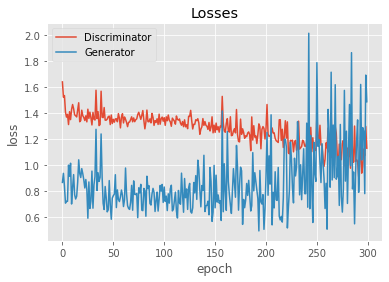

In [18]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

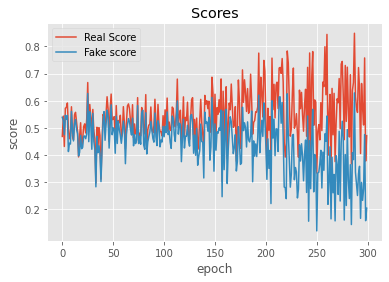

In [19]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.yticks([x * 0.1 for x in range(2,9)])
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [20]:
if not os.path.exists("./checkpoint/"):
    os.makedirs("./checkpoint/")
torch.save(
    G.state_dict(),
    "checkpoint/06.06_DcGAN_celebA_metrics_TTUR_Noise_label_smoothing_SN_Teacher-Baseline(x4-features)_wider-latent_generator_model.pth")
torch.save(
    D.state_dict(),
    "checkpoint/06.06_DcGAN_celebA_metrics_TTUR_Noise_label_smoothing_SN_Teacher-Baseline(x4-features)_wider-latent_discrimator_model.pth")

In [21]:
G.load_state_dict(torch.load("checkpoint/06.06_DcGAN_celebA_metrics_TTUR_Noise_label_smoothing_SN_Teacher-Baseline(x4-features)_wider-latent_generator_model.pth"))
D.load_state_dict(torch.load( "checkpoint/06.06_DcGAN_celebA_metrics_TTUR_Noise_label_smoothing_SN_Teacher-Baseline(x4-features)_wider-latent_discrimator_model.pth"))

<All keys matched successfully>

### Measuring performance

install library from https://github.com/w86763777/pytorch-gan-metrics.git </br>
Currently, this package supports following metrics:

* Inception Score (IS)
* Fréchet Inception Distance (FID)

In [22]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
# !git clone https://github.com/w86763777/pytorch-gan-metrics.git
# !pip install pytorch-gan-metrics --user

In [23]:
# Prepare Statistics for FID (if version not compatible, run it on colab and download results)
# !python -m pytorch_gan_metrics.calc_fid_stats --path ./data/celeba/img_align_celeba/img_align_celeba --output ./stats.npz

#### calculate the Inception Score (IS) and Fréchet Inception Distance (FID)

In [24]:
# import function from pytorch_gan_metrics 
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim
    
    def __len__(self):
        return 512
    
    def __getitem__(self, index):
        return self.G(get_latent_vector(batch_size = 1).to(config.device))[0]

In [25]:
g_set = GeneratorDataset(G, config.latent_size)
g_loader = DataLoader(g_set, batch_size=config.batch_size, shuffle=True, drop_last=False)

In [27]:
# Inception Score
IS, IS_std = get_inception_score(g_loader)
print(f"Inception Score: {IS} (std: {IS_std})")
# Frechet Inception Distance
FID = get_fid(g_loader, './stats.npz')
print(f"FID socre: {FID}")

Inception Score: 2.2667971182041335 (std: 0.11157324914947513)
FID socre: 131.79442266324074


### Geometry Score

from this repo: https://github.com/KhrulkovV/geometry-score
It is a novel measure of performance of a GAN by comparing geometrical properties of the underlying data manifold and the generated one, which provides both qualitative and quantitative means for evaluation. 

![Geometry Score](https://github.com/KhrulkovV/geometry-score/blob/master/assets/manif.png?raw=true)

In [36]:
# !pip install gudhi
# !git clone https://github.com/KhrulkovV/geometry-score.git

In [37]:
sys.path.insert(0, "./geometry-score")
import gs
for i, (images) in enumerate(data_loader):
    x = images.numpy()
    break
print(x.shape)
x = np.reshape(x, (-1, 3*64*64))
rltx = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)

(128, 3, 64, 64)
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100


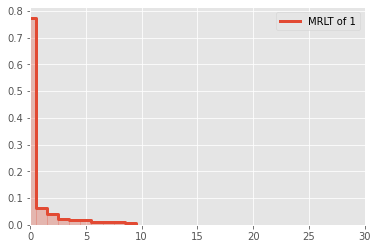

In [38]:
mrlt = np.mean(rltx, axis=0)
gs.fancy_plot(mrlt, label='MRLT of 1')
plt.xlim([0, 30])
plt.legend()

In [39]:
dataset = GeneratorDataset(G, config.latent_size)
loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, drop_last=False)
for i, (images) in enumerate(loader):
    x = images.detach().cpu().numpy()
    break
print(x.shape)
x = np.reshape(x, (-1, 3*64*64))
rlty = gs.rlts(x, n=100, L_0=32, i_max=10, gamma=1.0/8)

(128, 3, 64, 64)
Done 0/100
Done 10/100
Done 20/100
Done 30/100
Done 40/100
Done 50/100
Done 60/100
Done 70/100
Done 80/100
Done 90/100


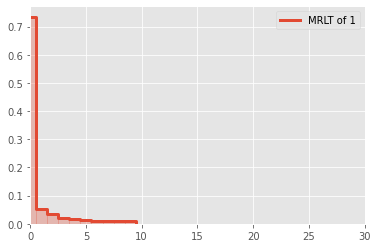

In [40]:
mrlt = np.mean(rlty, axis=0)
gs.fancy_plot(mrlt, label='MRLT of 1')
plt.xlim([0, 30])
plt.legend()

In [41]:
gs.geom_score(rltx, rlty)

0.0017272066953148077

### Test the performance

In [42]:
D = D.eval()
G = G.eval()

In [43]:
predicted = 0
count = 0
for i, images in enumerate(data_loader):
    images = images.to(config.device)
    outputs, _ = D(images)
    count += len(outputs)
    predicted = predicted + outputs.sum().item()

In [44]:
score = predicted / count 
print(f"Real score = {score:0.4f}")

Real score = 0.5508


In [45]:
predicted_fake = 0
count_fake = 0
for i in tqdm(range (len(data_loader))):
    z = get_latent_vector(batch_size = config.batch_size).to(config.device)
    noise = config.noise_coef * np.random.uniform() * torch.amax(z)    
    z = z + (noise.to(config.device) * torch.randn(size=z.shape).to(config.device))
    fake_images = G(z)
    outputs, _ = D(fake_images)
    count_fake += len(outputs)
    predicted_fake = predicted_fake + outputs.sum().item()

100%|██████████████████████████████████████████████████████████████████████████████| 1582/1582 [01:17<00:00, 20.38it/s]


In [46]:
score_fake = predicted_fake / count_fake
print(f"Fake score = {score_fake:0.2f}")

Fake score = 0.32


In [47]:
fake_fname = 'TEST_fake_images.png'
print('Saving', fake_fname)
save_image(denorm(fake_images), os.path.join(config.sample_dir, fake_fname), nrow= 16)

Saving TEST_fake_images.png


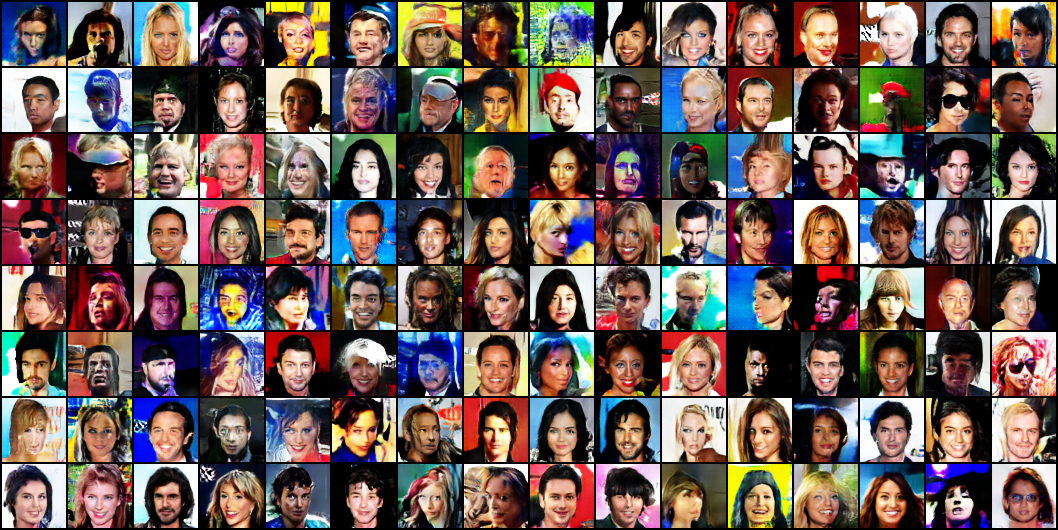

In [48]:
#show result/image
Image.open(os.path.join(config.sample_dir, fake_fname))

In [49]:
summary(D, input_size=(3, 64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      SpectralNorm-1          [-1, 128, 32, 32]               0
         LeakyReLU-2          [-1, 128, 32, 32]               0
      SpectralNorm-3          [-1, 256, 16, 16]               0
       BatchNorm2d-4          [-1, 256, 16, 16]             512
         LeakyReLU-5          [-1, 256, 16, 16]               0
      SpectralNorm-6            [-1, 512, 8, 8]               0
       BatchNorm2d-7            [-1, 512, 8, 8]           1,024
         LeakyReLU-8            [-1, 512, 8, 8]               0
      SpectralNorm-9           [-1, 1024, 4, 4]               0
      BatchNorm2d-10           [-1, 1024, 4, 4]           2,048
        LeakyReLU-11           [-1, 1024, 4, 4]               0
     SpectralNorm-12              [-1, 1, 1, 1]               0
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 3,584
Trainable params: 3